<a href="https://colab.research.google.com/github/kozoB/steam-sarcasm-detection/blob/main/Steam_Reviews_Sarcasm_Detection_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Steam Reviews Sarcasm Detection

# Imports

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification
import torch
from torch.utils.data import Dataset, DataLoader

# Load Dataset

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Read the CSV file
dataset_path = '/content/drive/MyDrive/Masters Degree/NLP Course/Steam Reviews Sarcasm Detection Project/dataset/steam_reviews_dataset_labeled.csv'
steam_reviews = pd.read_csv(dataset_path)

# Display the first few rows
steam_reviews.head()

Mounted at /content/drive


,app_id,app_name,review_text,review_score,review_votes,sarcasm_label
0,10,Counter-Strike,Ruined my life.,1,0,1
1,10,Counter-Strike,This game saved my virginity.,1,0,1
2,10,Counter-Strike,â€¢ Do you like original games? â€¢ Do you lik...,1,0,1
3,10,Counter-Strike,"Easy to learn, hard to master.",1,1,0
4,10,Counter-Strike,"No r8 revolver, 10/10 will play again.",1,1,1


In [4]:
print(f"steam_reviews shape:\n{steam_reviews.shape}\n")
print(f"{steam_reviews['sarcasm_label'].value_counts()}")

steam_reviews shape:
(563, 6)

sarcasm_label
0    313
1    250
Name: count, dtype: int64


# Exploratory Data Analysis (EDA) and Feature Engineering

## Label Distribution

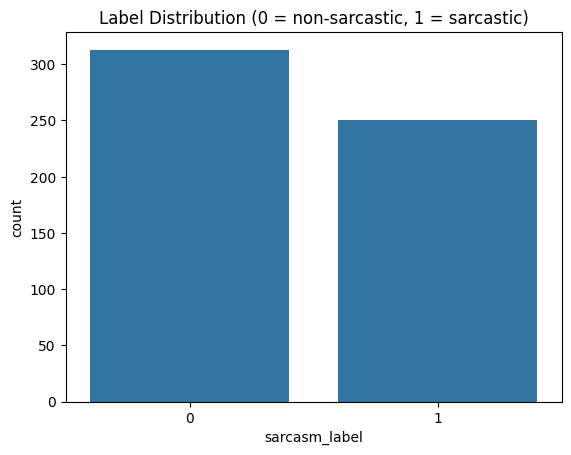

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='sarcasm_label', data=steam_reviews)
plt.title("Label Distribution (0 = non-sarcastic, 1 = sarcastic)")
plt.show()

## Review Score vs. Sarcasm Correlation

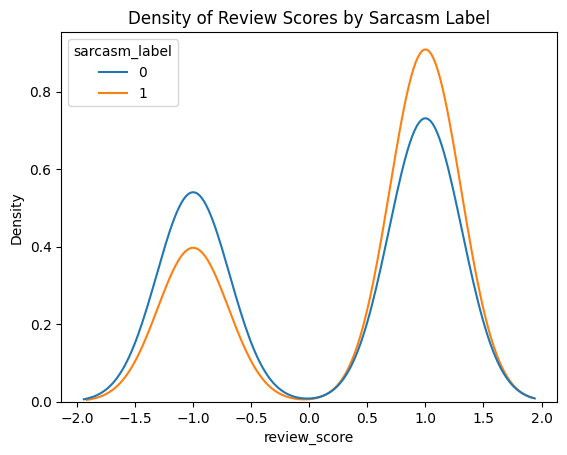

In [6]:
sns.kdeplot(data=steam_reviews, x='review_score', hue='sarcasm_label', common_norm=False)
plt.title("Density of Review Scores by Sarcasm Label")
plt.show()

This plot shows the distribution of review scores for sarcastic and non-sarcastic Steam reviews. While both classes contain a mix of positive (+1) and negative (-1) review scores, sarcastic reviews tend to be skewed more toward positive scores. This suggests that many sarcastic reviews outwardly "recommend" the game, likely using irony to express dissatisfaction - a common sarcasm pattern. In contrast, non-sarcastic reviews display a more balanced distribution between negative and positive scores. This highlights a key challenge in sarcasm detection: sarcastic comments may appear positive in rating but convey negative sentiment in text. As a result, the review_score feature may be misleading on its own, but when combined with text, it becomes a valuable signal for distinguishing genuine praise from sarcasm.

## Density of Review Votes By Srcasm Label

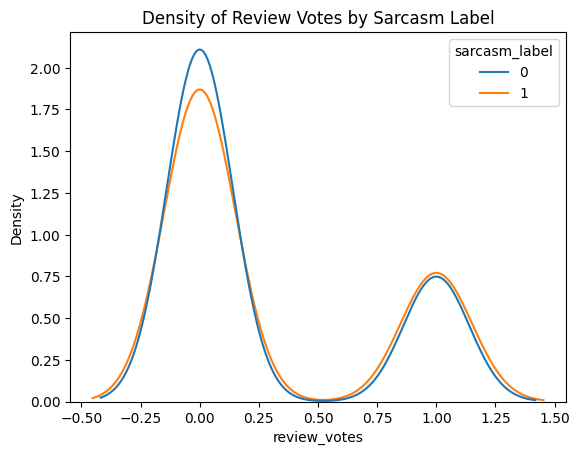

In [7]:
sns.kdeplot(data=steam_reviews, x='review_votes', hue='sarcasm_label', common_norm=False)
plt.title("Density of Review Votes by Sarcasm Label")
plt.show()

The distribution of 'review_votes' reveals that both sarcastic and non-sarcastic reviews typically receive few or no votes, with a sharp peak near zero.
However, sarcastic reviews show a slightly higher density at the upper end, suggesting that sarcastic content may be more engaging or memorable, making it more likely to be voted as helpful by other users. While this feature alone may not be strongly discriminative, it could still carry subtle signal when combined with textual features in a multimodal sarcasm detection model. Therefore, 'review_votes' is retained as a metadata feature during training.

## Density of Sentiment By Sarcasm Label

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


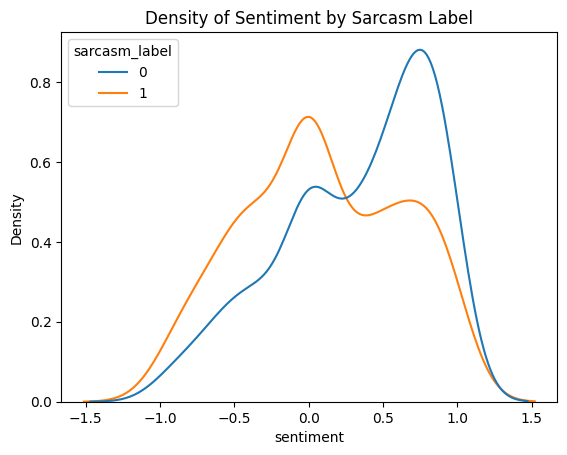

In [8]:
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

steam_reviews['sentiment'] = steam_reviews['review_text'].apply(lambda x: sia.polarity_scores(str(x))['compound'])

sns.kdeplot(data=steam_reviews, x='sentiment', hue='sarcasm_label', common_norm=False)
plt.title("Density of Sentiment by Sarcasm Label")
plt.show()

Sentiment analysis using VADER reveals that sarcastic reviews tend to cluster around neutral or slightly negative sentiment scores, whereas non-sarcastic reviews skew strongly positive. This divergence highlights a common sarcasm pattern: expressing negative opinions using superficially positive language. The sentiment distribution supports the inclusion of sentiment polarity as a metadata feature and also suggests that mismatches between sentiment and review score may serve as effective sarcasm indicators.

## Bidirectional Sentiment Mismatch By Sarcasm Label

In [9]:
# Sentiment mismatch
steam_reviews['sentiment_mismatch'] = (
    ((steam_reviews['review_score'] == 1) & (steam_reviews['sentiment'] < 0.2)) |
    ((steam_reviews['review_score'] == -1) & (steam_reviews['sentiment'] > 0.2))
).astype(int)


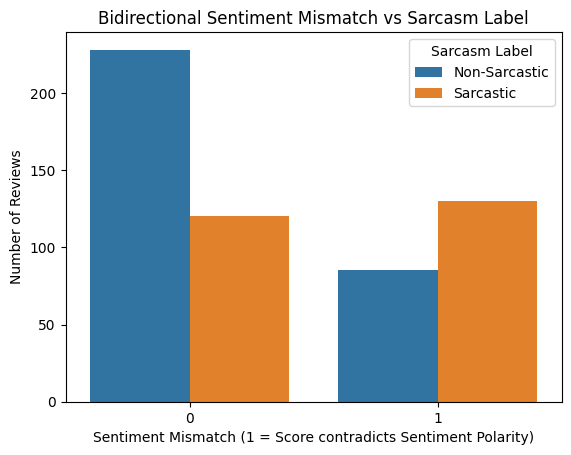

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='sentiment_mismatch', hue='sarcasm_label', data=steam_reviews)
plt.title("Bidirectional Sentiment Mismatch vs Sarcasm Label")
plt.xlabel("Sentiment Mismatch (1 = Score contradicts Sentiment Polarity)")
plt.ylabel("Number of Reviews")
plt.legend(title='Sarcasm Label', labels=['Non-Sarcastic', 'Sarcastic'])
plt.show()


The sentiment_mismatch feature flags reviews where the recommendation score contradicts the sentiment of the review text — either a positive score with neutral or negative sentiment, or a negative score with positive sentiment. This bidirectional approach captures a broader range of sarcasm patterns. As shown in the plot, sarcastic reviews are significantly more likely to exhibit such mismatches, whereas non-sarcastic reviews tend to show consistency between rating and sentiment. This supports the idea that sarcasm often relies on ironic contrast between what is said (text) and what is implied (rating), making sentiment_mismatch a valuable and interpretable metadata feature for sarcasm detection models.

In [11]:
# Has ALL CAPS words
steam_reviews['has_caps'] = steam_reviews['review_text'].str.contains(r'[A-Z]{3,}').astype(int)

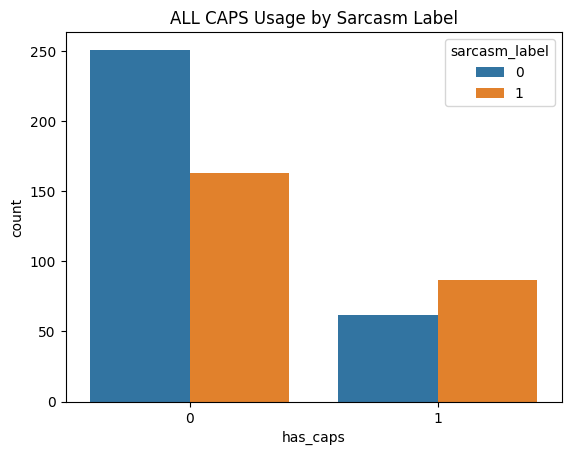

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='has_caps', hue='sarcasm_label', data=steam_reviews)
plt.title("ALL CAPS Usage by Sarcasm Label")
plt.show()

In [13]:
from scipy.stats import pointbiserialr

corr, p = pointbiserialr(steam_reviews['has_caps'], steam_reviews['sarcasm_label'])
print(f"{'has_caps'}: r = {corr:.3f}, p = {p:.3f}")

has_caps: r = 0.169, p = 0.000


In [14]:
# Prepare the features and labels for modeling by removing game-specific identifiers
# 'app_id' and 'app_name' are excluded to prevent model overfitting to specific games
steam_review_features = steam_reviews.drop(columns=['app_id', 'app_name'])

In [15]:
steam_review_features

,review_text,review_score,review_votes,sarcasm_label,sentiment,sentiment_mismatch,has_caps
0,Ruined my life.,1,0,1,-0.4767,1,0
1,This game saved my virginity.,1,0,1,0.4215,0,0
2,â€¢ Do you like original games? â€¢ Do you lik...,1,0,1,0.9098,0,0
3,"Easy to learn, hard to master.",1,1,0,0.3612,0,0
4,"No r8 revolver, 10/10 will play again.",1,1,1,0.0516,1,0
...,...,...,...,...,...,...,...
558,I tried this when it was free to play. It is j...,-1,0,0,0.4019,1,0
559,"The mechanics of this game are so broken, it's...",1,0,1,0.0445,1,0
560,They misspelled 'Died' 10/10,1,0,1,0.0000,1,0
561,.99 cents and it still isn't worth the money.,-1,0,0,-0.1695,0,0


## Split Data To Train And Test Sets

In [16]:
from sklearn.model_selection import train_test_split

# Randomized split (90% train, 10% test)
train_df, test_df = train_test_split(
    steam_review_features,
    test_size=0.1,
    stratify=steam_review_features['sarcasm_label'],  # Ensures balanced class distribution
    random_state=42      # For reproducibility
)

# Review Text Only Experiment

### Create Train And Test Sets with Relevant Features

In [17]:
# Text-only versions for model experiment
text_train_df = train_df[['review_text', 'sarcasm_label']]
text_test_df = test_df[['review_text', 'sarcasm_label']]

## Zero Shot

In [18]:
from transformers import pipeline
from sklearn.metrics import classification_report
import pandas as pd

# Initialize zero-shot pipeline with a pre-trained model
zero_shot_classifier = pipeline(
    "zero-shot-classification",
    model="FacebookAI/roberta-large-mnli"  # Correct model identifier
)

# Define the candidate labels for sarcasm detection
candidate_labels = ["sarcastic", "not sarcastic"]

# Create empty lists to store predictions and confidence scores
predictions = []
confidence_scores = []

# Apply zero-shot prediction on test data with confidence scores
for review in text_test_df['review_text']:
    result = zero_shot_classifier(review, candidate_labels)
    predicted_label = result['labels'][0]
    confidence_score = result['scores'][0]

    predictions.append(predicted_label)
    confidence_scores.append(confidence_score)

# Add predictions and confidence scores to the DataFrame
text_test_df['zero_shot_prediction'] = predictions
text_test_df['confidence_score'] = confidence_scores

# Map predictions to 0 (not sarcastic) or 1 (sarcastic)
text_test_df['zero_shot_prediction_numeric'] = text_test_df['zero_shot_prediction'].map({
    "sarcastic": 1,
    "not sarcastic": 0
})

# Create a column indicating if the prediction was correct
text_test_df['correct'] = (text_test_df['zero_shot_prediction_numeric'] == text_test_df['sarcasm_label'])

# Evaluate performance
print("\nZero-Shot Classification Report:")
print(classification_report(
    text_test_df['sarcasm_label'],
    text_test_df['zero_shot_prediction_numeric'],
    digits=4
))

# Display the results with confidence scores
print("\nZero-Shot Predictions with Confidence Scores:")
print(text_test_df[['review_text', 'zero_shot_prediction', 'confidence_score']].head(10))


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/688 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.43G [00:00<?, ?B/s]

Some weights of the model checkpoint at FacebookAI/roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset



Zero-Shot Classification Report:
              precision    recall  f1-score   support

           0     0.5758    0.5938    0.5846        32
           1     0.4583    0.4400    0.4490        25

    accuracy                         0.5263        57
   macro avg     0.5170    0.5169    0.5168        57
weighted avg     0.5243    0.5263    0.5251        57


Zero-Shot Predictions with Confidence Scores:
                                           review_text zero_shot_prediction  \
328          Yes, Illuminati reccomends it.  10/10 ign        not sarcastic   
120   IMHO this engine should be end on single player.            sarcastic   
198                     WHY CANT I GET IT TO WORK???!!            sarcastic   
303  for me is this the best call of duty ;D TIP bu...        not sarcastic   
81   Very fun game, It's a classic and the only rea...        not sarcastic   
424                  unbalanced multiplayer. refunded.        not sarcastic   
529  It's a decent game i guess. A litt

<ipython-input-18-6391fdbcdc7a>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_test_df['zero_shot_prediction'] = predictions
<ipython-input-18-6391fdbcdc7a>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_test_df['confidence_score'] = confidence_scores
<ipython-input-18-6391fdbcdc7a>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

In [19]:
text_test_df.head(3)

,review_text,sarcasm_label,zero_shot_prediction,confidence_score,zero_shot_prediction_numeric,correct
328,"Yes, Illuminati reccomends it. 10/10 ign",1,not sarcastic,0.901123,0,False
120,IMHO this engine should be end on single player.,0,sarcastic,0.529524,1,False
198,WHY CANT I GET IT TO WORK???!!,0,sarcastic,0.605391,1,False


### Confidence Distribution Histogram

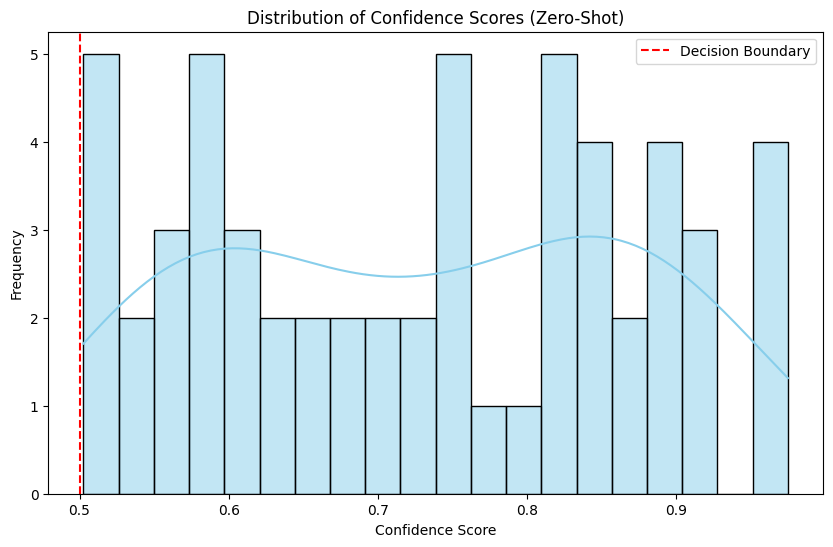

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(text_test_df['confidence_score'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Confidence Scores (Zero-Shot)')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.axvline(0.5, color='red', linestyle='--', label='Decision Boundary')
plt.legend()
plt.show()

The confidence distribution histogram reveals that the model's confidence scores are spread across a wide range, from 0.5 to 0.9.

There is no single dominant peak, but there are two slight peaks around 0.5 (uncertain) and 0.8 (confident).

The model frequently makes predictions with relatively high confidence (0.7 to 0.9), but it also has a notable cluster of predictions near the decision boundary (0.5), where it is less certain.

The wavy shape of the KDE line suggests that the model's confidence is somewhat inconsistent.

### Confidence by Correct/Incorrect Predictions

Average Confidence (Correct): 0.7712
Average Confidence (Incorrect): 0.6848


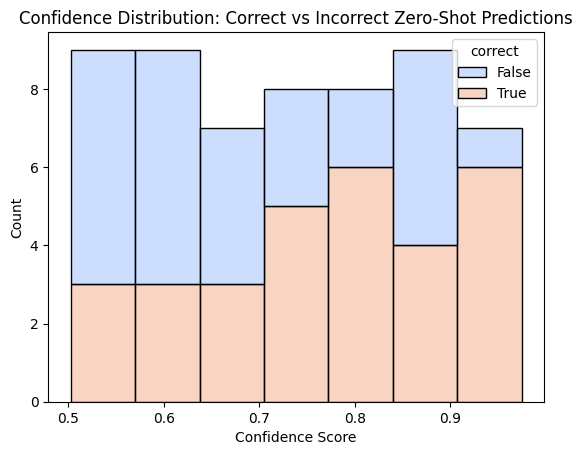

In [21]:
# Create a column indicating if the prediction was correct
correct_conf = text_test_df[text_test_df['correct'] == True]['confidence_score'].mean()
incorrect_conf = text_test_df[text_test_df['correct'] == False]['confidence_score'].mean()
print(f"Average Confidence (Correct): {correct_conf:.4f}")
print(f"Average Confidence (Incorrect): {incorrect_conf:.4f}")

# Plot confidence scores for correct vs incorrect predictions
sns.histplot(data=text_test_df, x='confidence_score', hue='correct',
             multiple='stack', palette="coolwarm", alpha=0.6)
plt.title("Confidence Distribution: Correct vs Incorrect Zero-Shot Predictions")
plt.xlabel("Confidence Score")
plt.show()

Lower confidence score are associated with fewer correct predictions.
This is expected, as the model is more "unsure" and less reliable at lower confidence levels.

At higher confidence scores, correct predictions become more frequent, but there are still several incorrect predictions - indicating that the model can be overconfident in its wrong answers.

- Average Confidence (Correct): 0.7712 - The model is reasonably confident when it is correct.
- Average Confidence (Incorrect): 0.6848 - The model is still fairly confident even when it is wrong, which is problematic.

### Precision-Recall Curve

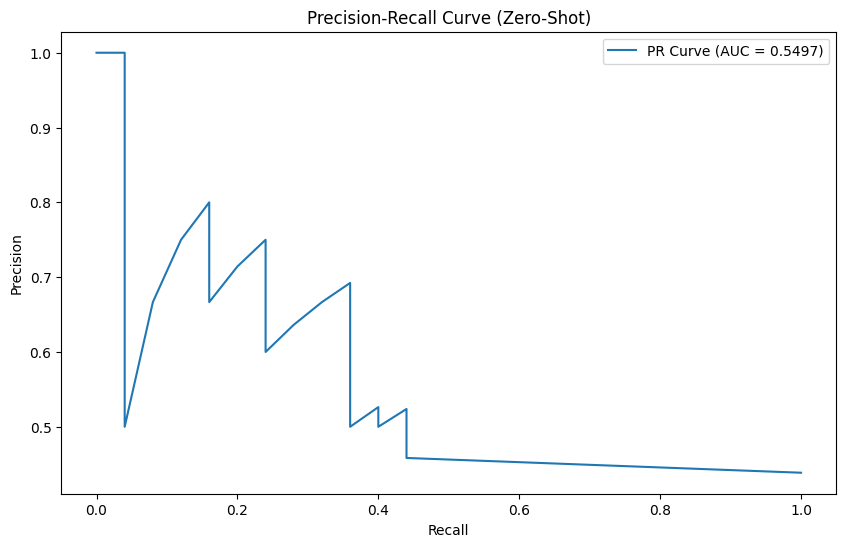

In [22]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# Calculate precision-recall for sarcasm (class 1)
precision, recall, _ = precision_recall_curve(
    text_test_df['sarcasm_label'],
    text_test_df['confidence_score'] * text_test_df['zero_shot_prediction_numeric']  # Use confidence only for positive class
)

# Calculate area under the curve
pr_auc = auc(recall, precision)

# Plot Precision-Recall Curve
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, label=f'PR Curve (AUC = {pr_auc:.4f})')
plt.title("Precision-Recall Curve (Zero-Shot)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()

The Precision-Recall (PR) curve visualizes the trade-off between precision and recall for detecting sarcastic reviews using the zero-shot model. As recall increases (capturing more sarcastic reviews), precision decreases, indicating that the model misclassifies more non-sarcastic reviews as sarcastic.

The area under the curve (AUC) is 0.5497, which is only slightly above 0.5, suggesting that the model is close to random guessing for this task. The sharp fluctuations in the curve show that the model's performance is inconsistent, likely because it lacks any training specifically for sarcasm detection.

These results highlight the model's difficulty in maintaining high precision without sacrificing recall and confirm the need for fine-tuning or few-shot learning.

### Confusion Matrix

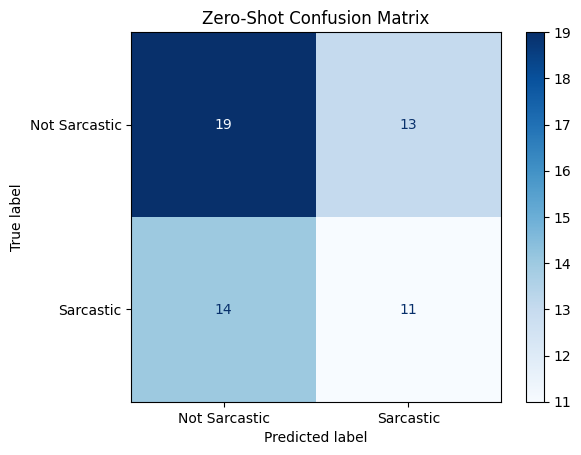

In [23]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cm = confusion_matrix(
    text_test_df['sarcasm_label'],
    text_test_df['zero_shot_prediction_numeric']
)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Sarcastic", "Sarcastic"])
disp.plot(cmap="Blues")
plt.title("Zero-Shot Confusion Matrix")
plt.show()

### Prediction Distribution

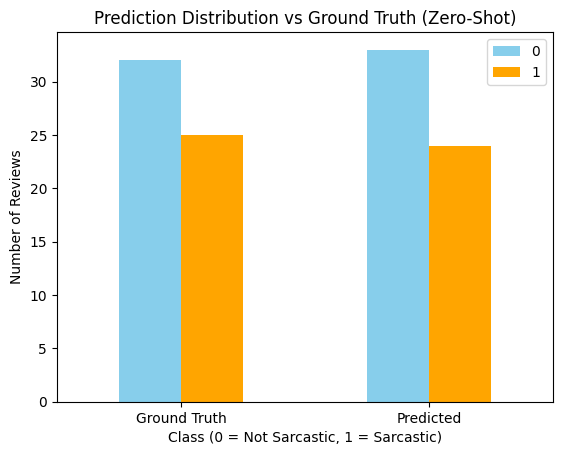

In [24]:
import matplotlib.pyplot as plt

# Count the ground truth labels
ground_truth_counts = text_test_df['sarcasm_label'].value_counts()
predicted_counts = text_test_df['zero_shot_prediction_numeric'].value_counts()

# Combine into a DataFrame for easy plotting
comparison_df = pd.DataFrame({
    'Ground Truth': ground_truth_counts,
    'Predicted': predicted_counts
}).T

# Plot the distribution
comparison_df.plot(kind='bar', color=['skyblue', 'orange'])
plt.title("Prediction Distribution vs Ground Truth (Zero-Shot)")
plt.xticks(rotation=0)
plt.xlabel("Class (0 = Not Sarcastic, 1 = Sarcastic)")
plt.ylabel("Number of Reviews")
plt.show()

Although the predicted distribution is relatively close to the actual distribution, the model shows a slight tendency to over-predict "not sarcastic" reviews (blue), while slightly under-predicting "sarcastic" ones (orange). This indicates a minor bias towards the non-sarcastic class, which is common when the model is more confident in its safer predictions

### Confidence by Prediction Type

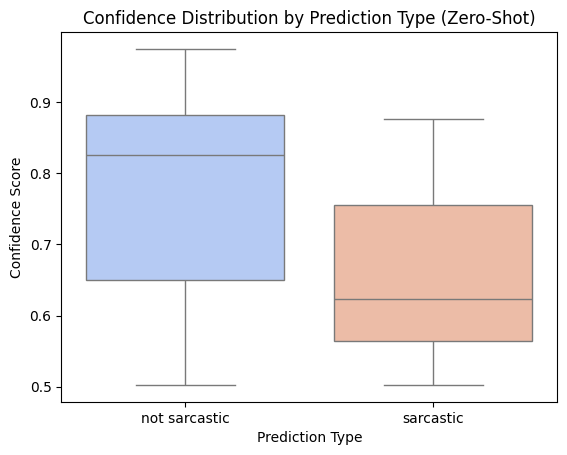

In [25]:
sns.boxplot(
    x='zero_shot_prediction',
    y='confidence_score',
    data=text_test_df,
    hue='zero_shot_prediction',
    palette="coolwarm"
)
plt.title("Confidence Distribution by Prediction Type (Zero-Shot)")
plt.xlabel("Prediction Type")
plt.ylabel("Confidence Score")
plt.show()

The box plot indicates that the model tends to be more confident in its predictions of "not sarcastic" reviews compared to "sarcastic" ones. This is shown by the higher median confidence score for "not sarcastic" predictions, while the "sarcastic" predictions have a lower median and a narrower range.

This pattern is consistent with the model's overall behavior, where it more frequently predicts "not sarcastic." Such an imbalance in predictions can naturally lead to greater confidence in the majority class, even if the model is not necessarily more accurate.

## One Shot

In [26]:
# Set Pandas to display full text in DataFrames
pd.set_option('display.max_colwidth', None)

label_map = {0: "not sarcastic", 1: "sarcastic"}

# One-Shot Training Data Preparation
one_shot_train_df = pd.concat([
    text_train_df[text_train_df['sarcasm_label'] == 0].sample(1, random_state=42),
    text_train_df[text_train_df['sarcasm_label'] == 1].sample(1, random_state=42)
])

one_shot_train_df['textual_label'] = one_shot_train_df['sarcasm_label'].map(label_map)

print("\nOne-Shot Training Data:")
one_shot_train_df


One-Shot Training Data:


,review_text,sarcasm_label,textual_label
29,"haven't played much, but looks ok.",0,not sarcastic
364,"Good game. My friend got an AC1-30 2x, 1 EMP in a 3 care packages in Rust. I'm done. GG",1,sarcastic


In [27]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Initialize tokenizer and model with ignore_mismatched_sizes=True
tokenizer = AutoTokenizer.from_pretrained("FacebookAI/roberta-large-mnli")
one_shot_classifier = AutoModelForSequenceClassification.from_pretrained(
    "FacebookAI/roberta-large-mnli",
    num_labels=2,
    ignore_mismatched_sizes=True
)

Some weights of the model checkpoint at FacebookAI/roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-large-mnli and are newly initialized because the shapes did not match:
- classifier.out_proj.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instanti

In [28]:
# Tokenize the one-shot training data
train_encodings = tokenizer(
    list(one_shot_train_df['review_text']),
    padding=True,
    truncation=True,
    return_tensors="pt"
)

# Prepare labels for one-shot (0 = not sarcastic, 1 = sarcastic)
train_labels = torch.tensor(one_shot_train_df['sarcasm_label'].values)

print("\nOne-Shot Tokenized Data:")
print(train_encodings)


One-Shot Tokenized Data:
{'input_ids': tensor([[    0, 15159,    75,   702,   203,     6,    53,  1326, 15983,     4,
             2,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1],
        [    0, 12350,   177,     4,  1308,  1441,   300,    41,  7224,   134,
            12,   541,   132,  1178,     6,   112, 42384,    11,    10,   155,
           575,  8368,    11, 23083,     4,    38,   437,   626,     4, 43934,
             2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1]])}


In [29]:
from torch.utils.data import DataLoader, TensorDataset

# Create a DataLoader with one-shot data
one_shot_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels)
one_shot_loader = DataLoader(one_shot_dataset, batch_size=2)

optimizer = torch.optim.AdamW(one_shot_classifier.parameters(), lr=5e-5)

# Fine-Tune (One-Shot)
one_shot_classifier.train()
for epoch in range(3):  # Small number of epochs for one-shot
    for batch in one_shot_loader:
        inputs, masks, labels = batch
        outputs = one_shot_classifier(input_ids=inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

print("\nOne-Shot Training Complete.")


One-Shot Training Complete.


In [30]:
one_shot_classifier.eval()  # Set model to evaluation mode

# Initialize lists for one-shot predictions and confidence scores
one_shot_predictions = []
one_shot_confidences = []

# Apply one-shot prediction on test data with confidence scores
for review in text_test_df['review_text']:
    inputs = tokenizer(review, return_tensors="pt", padding=True, truncation=True)
    outputs = one_shot_classifier(**inputs)

    # Get predicted label (0 or 1)
    logits = outputs.logits
    predicted_label = torch.argmax(logits, dim=1).item()
    one_shot_predictions.append(predicted_label)

    # Calculate confidence score using softmax
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    confidence_score = probabilities[0][predicted_label].item()
    one_shot_confidences.append(confidence_score)

# Add one-shot predictions and confidence scores to the DataFrame
text_test_df['one_shot_prediction_numeric'] = one_shot_predictions
text_test_df['one_shot_confidence_score'] = one_shot_confidences

# Map numeric predictions to text labels (for readability)
text_test_df['one_shot_prediction'] = text_test_df['one_shot_prediction_numeric'].map({
    1: "sarcastic",
    0: "not sarcastic"
})

# Create a column indicating if the one-shot prediction was correct
text_test_df['one_shot_correct'] = (text_test_df['one_shot_prediction_numeric'] == text_test_df['sarcasm_label'])

# Evaluate performance
print("\nOne-Shot Classification Report:")
print(classification_report(
    text_test_df['sarcasm_label'],
    text_test_df['one_shot_prediction_numeric'],
    digits=4
))

# Display the One-Shot predictions with confidence scores
print("\nOne-Shot Predictions with Confidence Scores:")
print(text_test_df[['review_text', 'one_shot_prediction', 'one_shot_confidence_score']].head(10))


One-Shot Classification Report:
              precision    recall  f1-score   support

           0     0.5614    1.0000    0.7191        32
           1     0.0000    0.0000    0.0000        25

    accuracy                         0.5614        57
   macro avg     0.2807    0.5000    0.3596        57
weighted avg     0.3152    0.5614    0.4037        57


One-Shot Predictions with Confidence Scores:
                                                                                                                                                                review_text  \
328                                                                                                                               Yes, Illuminati reccomends it.  10/10 ign   
120                                                                                                                        IMHO this engine should be end on single player.   
198                                                                  

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [31]:
text_test_df.head(3)

,review_text,sarcasm_label,zero_shot_prediction,confidence_score,zero_shot_prediction_numeric,correct,one_shot_prediction_numeric,one_shot_confidence_score,one_shot_prediction,one_shot_correct
328,"Yes, Illuminati reccomends it. 10/10 ign",1,not sarcastic,0.901123,0,False,0,0.588522,not sarcastic,False
120,IMHO this engine should be end on single player.,0,sarcastic,0.529524,1,False,0,0.634955,not sarcastic,True
198,WHY CANT I GET IT TO WORK???!!,0,sarcastic,0.605391,1,False,0,0.568840,not sarcastic,True


### Confidence Distribution

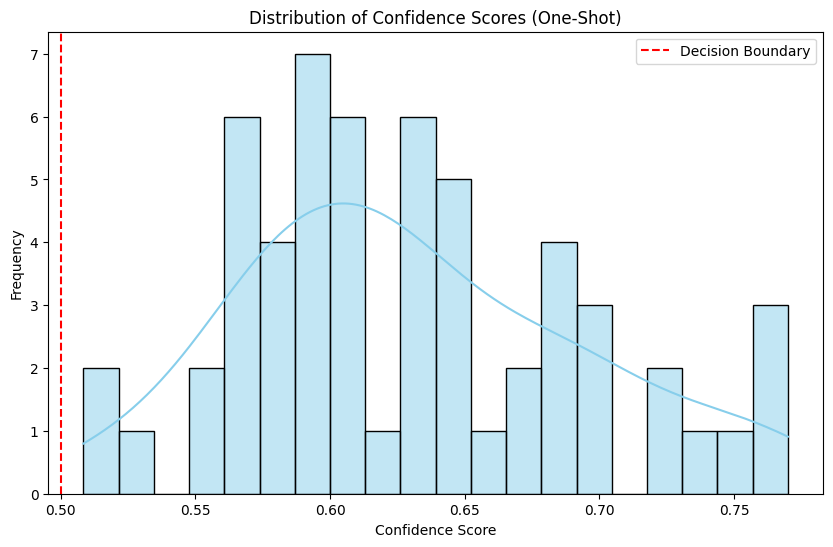

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(text_test_df['one_shot_confidence_score'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Confidence Scores (One-Shot)')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.axvline(0.5, color='red', linestyle='--', label='Decision Boundary')
plt.legend()
plt.show()

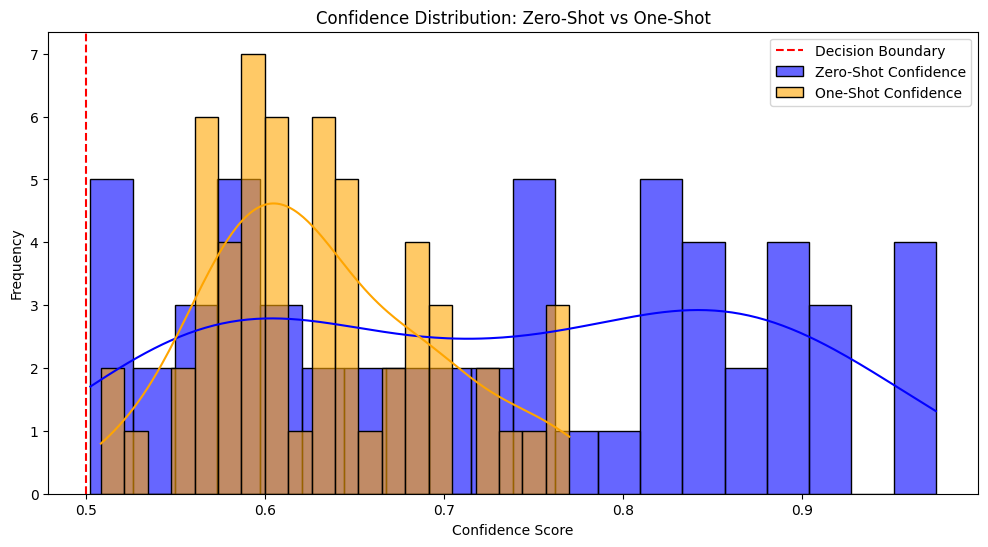

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))

# Zero-Shot Confidence Distribution (Blue)
sns.histplot(text_test_df['confidence_score'], bins=20, kde=True, color='blue', label='Zero-Shot Confidence', alpha=0.6)

# One-Shot Confidence Distribution (Orange)
sns.histplot(text_test_df['one_shot_confidence_score'], bins=20, kde=True, color='orange', label='One-Shot Confidence', alpha=0.6)

# Red Decision Boundary
plt.axvline(0.5, color='red', linestyle='--', label='Decision Boundary')

# Titles and Labels
plt.title('Confidence Distribution: Zero-Shot vs One-Shot')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [34]:
# Calculating Average Confidence Scores
zero_shot_avg = text_test_df.groupby('zero_shot_prediction')['confidence_score'].mean()
one_shot_avg = text_test_df.groupby('one_shot_prediction')['one_shot_confidence_score'].mean()

print("\nAverage Confidence (Zero-Shot):")
print(zero_shot_avg)
print("\nAverage Confidence (One-Shot):")
print(one_shot_avg)


Average Confidence (Zero-Shot):
zero_shot_prediction
not sarcastic    0.781376
sarcastic        0.660014
Name: confidence_score, dtype: float64

Average Confidence (One-Shot):
one_shot_prediction
not sarcastic    0.630483
Name: one_shot_confidence_score, dtype: float64


### Confidence by Correct/Incorrect Predictions

Average Confidence (Correct - One-Shot): 0.6434
Average Confidence (Incorrect - One-Shot): 0.6140


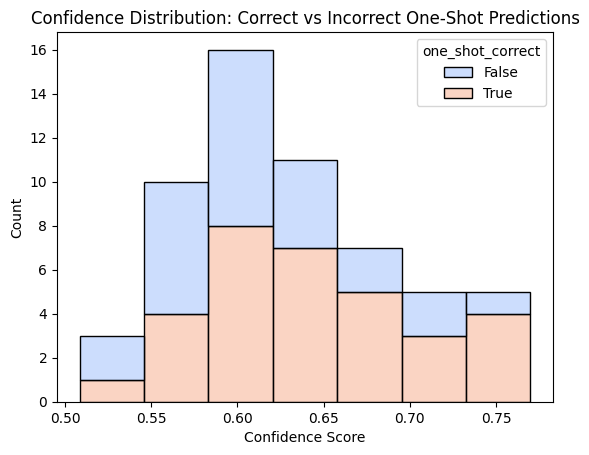

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a column indicating if the one-shot prediction was correct
text_test_df['one_shot_correct'] = (text_test_df['one_shot_prediction_numeric'] == text_test_df['sarcasm_label'])

# Calculate average confidence for correct and incorrect predictions in One-Shot
one_shot_correct_conf = text_test_df[text_test_df['one_shot_correct'] == True]['one_shot_confidence_score'].mean()
one_shot_incorrect_conf = text_test_df[text_test_df['one_shot_correct'] == False]['one_shot_confidence_score'].mean()

print(f"Average Confidence (Correct - One-Shot): {one_shot_correct_conf:.4f}")
print(f"Average Confidence (Incorrect - One-Shot): {one_shot_incorrect_conf:.4f}")

# Plot confidence scores for correct vs incorrect predictions (One-Shot)
sns.histplot(data=text_test_df, x='one_shot_confidence_score', hue='one_shot_correct',
             multiple='stack', palette="coolwarm", alpha=0.6)
plt.title("Confidence Distribution: Correct vs Incorrect One-Shot Predictions")
plt.xlabel("Confidence Score")
plt.show()

### Precision-Recall Curve

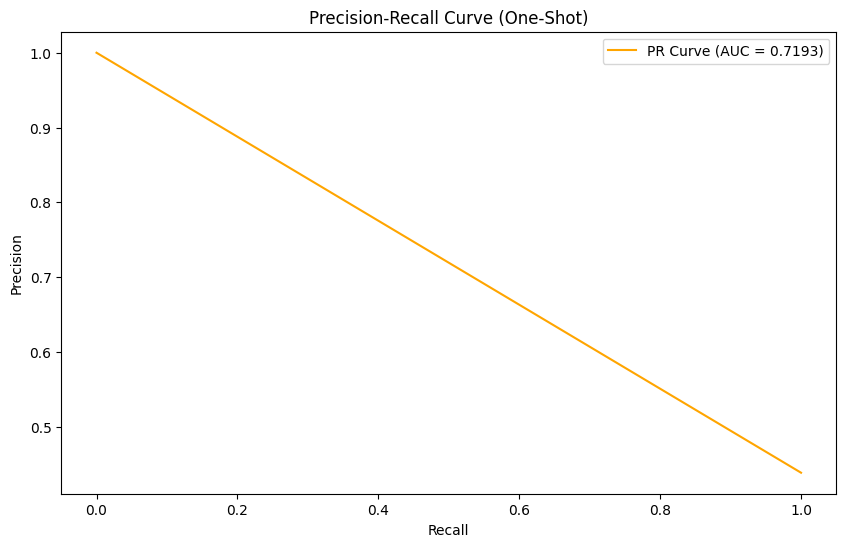

In [36]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# Calculate precision-recall for sarcasm (class 1) for One-Shot
precision, recall, _ = precision_recall_curve(
    text_test_df['sarcasm_label'],
    text_test_df['one_shot_confidence_score'] * text_test_df['one_shot_prediction_numeric']  # Use confidence only for positive class (sarcastic)
)

# Calculate area under the curve (AUC) for One-Shot
pr_auc_one_shot = auc(recall, precision)

# Plot Precision-Recall Curve (One-Shot)
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, label=f'PR Curve (AUC = {pr_auc_one_shot:.4f})', color='orange')
plt.title("Precision-Recall Curve (One-Shot)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()

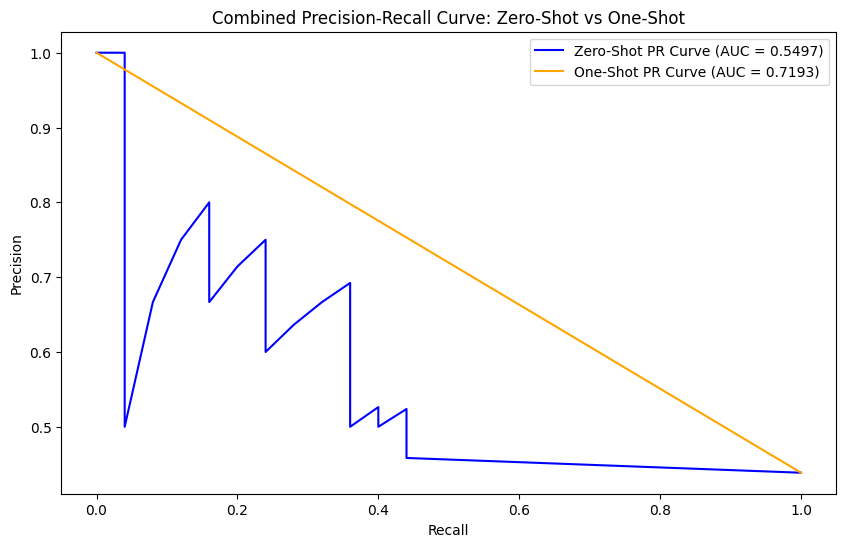

In [37]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# Calculate Precision-Recall for Zero-Shot
precision_zero, recall_zero, _ = precision_recall_curve(
    text_test_df['sarcasm_label'],
    text_test_df['confidence_score'] * text_test_df['zero_shot_prediction_numeric']
)
pr_auc_zero_shot = auc(recall_zero, precision_zero)

# Calculate Precision-Recall for One-Shot
precision_one, recall_one, _ = precision_recall_curve(
    text_test_df['sarcasm_label'],
    text_test_df['one_shot_confidence_score'] * text_test_df['one_shot_prediction_numeric']
)
pr_auc_one_shot = auc(recall_one, precision_one)

# Plotting the Combined PR Curve for Zero-Shot and One-Shot
plt.figure(figsize=(10, 6))
plt.plot(recall_zero, precision_zero, label=f'Zero-Shot PR Curve (AUC = {pr_auc_zero_shot:.4f})', color='blue')
plt.plot(recall_one, precision_one, label=f'One-Shot PR Curve (AUC = {pr_auc_one_shot:.4f})', color='orange')
plt.title("Combined Precision-Recall Curve: Zero-Shot vs One-Shot")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()

### Confusion Matrix

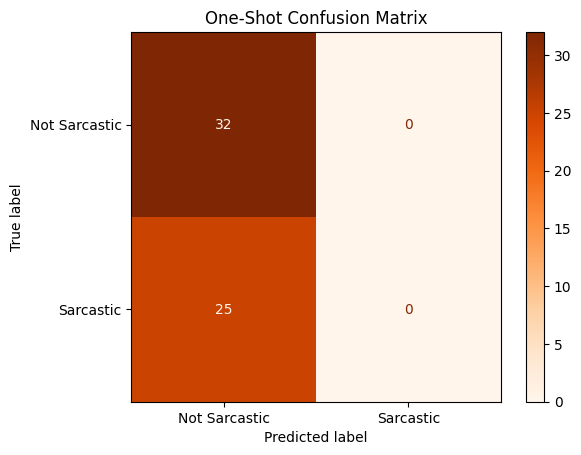

In [38]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

# Generate the confusion matrix for One-Shot predictions
cm_one_shot = confusion_matrix(
    text_test_df['sarcasm_label'],
    text_test_df['one_shot_prediction_numeric']
)

# Displaying the One-Shot Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_one_shot, display_labels=["Not Sarcastic", "Sarcastic"])
disp.plot(cmap="Oranges")
plt.title("One-Shot Confusion Matrix")
plt.show()

Complete bias towards the "Not sarcastic" label, the model completly avoids predicting sarcasm

### Prediction Distribution

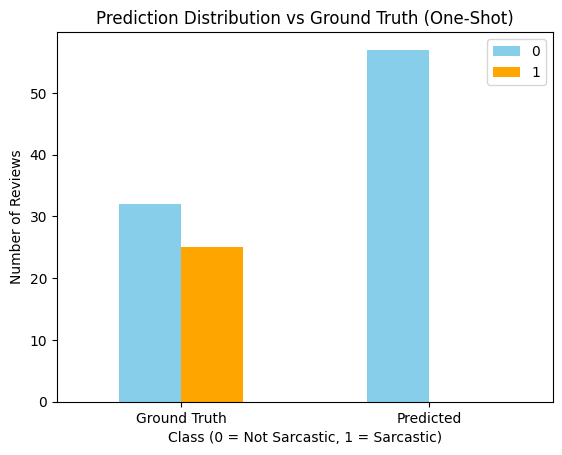

In [39]:
import matplotlib.pyplot as plt
import pandas as pd

# Count the ground truth labels
ground_truth_counts = text_test_df['sarcasm_label'].value_counts()
predicted_counts = text_test_df['one_shot_prediction_numeric'].value_counts()

# Combine into a DataFrame for easy plotting
comparison_df = pd.DataFrame({
    'Ground Truth': ground_truth_counts,
    'Predicted': predicted_counts
}).T

# Plot the distribution
comparison_df.plot(kind='bar', color=['skyblue', 'orange'])
plt.title("Prediction Distribution vs Ground Truth (One-Shot)")
plt.xticks(rotation=0)
plt.xlabel("Class (0 = Not Sarcastic, 1 = Sarcastic)")
plt.ylabel("Number of Reviews")
plt.show()

### Confidence by Prediction Type

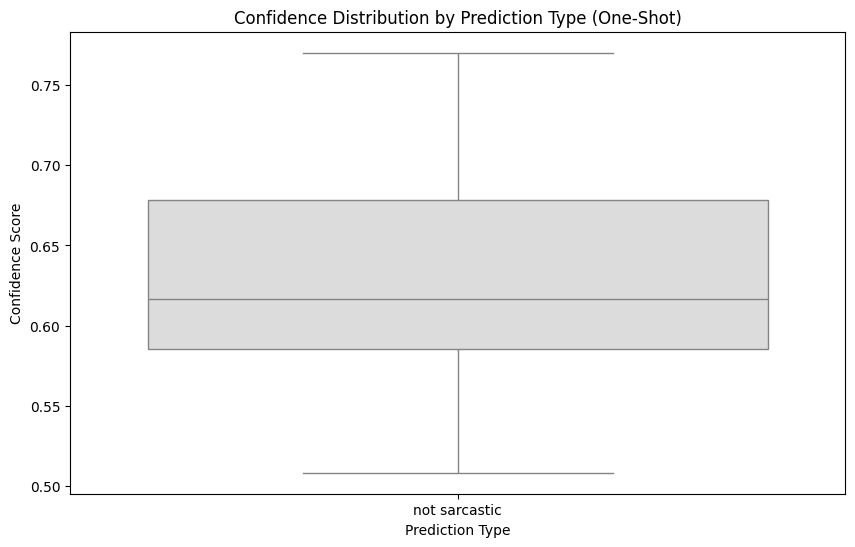

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting One-Shot Confidence Distribution by Prediction Type
plt.figure(figsize=(10, 6))
sns.boxplot(
    x='one_shot_prediction',
    y='one_shot_confidence_score',
    data=text_test_df,
    hue='one_shot_prediction',
    palette="coolwarm"
)
plt.title("Confidence Distribution by Prediction Type (One-Shot)")
plt.xlabel("Prediction Type")
plt.ylabel("Confidence Score")
plt.show()

## Few Shot

5 examples for sarcastic and 5 examples for non-sarcastic reviews

In [52]:
# Set the Few-Shot size (balanced)
few_shot_size = 10  # Can be 12, 16, or 20 if you prefer

# Select the Few-Shot examples (balanced between sarcastic and non-sarcastic)
few_shot_df = pd.concat([
    text_test_df[text_test_df['sarcasm_label'] == 1].sample(few_shot_size // 2, random_state=42),
    text_test_df[text_test_df['sarcasm_label'] == 0].sample(few_shot_size // 2, random_state=42)
])

# Display the Few-Shot Training Data
print("\nFew-Shot Training Data:")
few_shot_df[['review_text', 'sarcasm_label']]


Few-Shot Training Data:


,review_text,sarcasm_label
4,"No r8 revolver, 10/10 will play again.",1
510,"Super MNC... don't bother, no players and no fun. Play Smite instead. And never stop playing Smite or i will find you and make you download it slowly. I'm always watching!",1
328,"Yes, Illuminati reccomends it. 10/10 ign",1
161,"This game is not only the best game of the fps gender ever made but it is also the best game ever PERIOD. It is literally hundreds of games in one. You can drive cars, fly helicopters, fly planes, fly tie fighters, shoot lasers, play volleyball, play soccer, play football, play hide and go seek, ride bicycles, play dodgeball, immerse yourself in the warcraft world, be a superhero, be a surfer, be a rock climber. Oh yeah, you could also be a terrorist or counter-terrorist and plant/defuse bombs on dust 1 or dust 2. There are other maps but you don't really discover them until 10,000 hours in. But once you do it opens you up to a whole new world of wonders. This game gets a 10/10. The only games that compete are other version of counter-strike, Team Fortress Classic, and Day of Defeat. I would give it an 11/10 but there are no killstreaks.",1
535,I've recieved shots that where more fun than this game,1
558,I tried this when it was free to play. It is just an awful game.,0
136,It keeps kicking me for no reason :(,0
103,cool,0
300,"This is a great world war 2 game. It's probably one of the best, if not the best recent world war 2 game. The story isn't the best, characters aren't very memorable, although their are some epic moments in the campaign. Zombies is still amazing and the mods make the zombie mode much more enjoyable. 8.5/10",0
405,"I'm suprised I can still find full lobbies, but it's dying, slowly.",0


# Review Text With Metadata And Additional Features Experiment